In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random
import numpy as np

In [2]:
from albumentations import (
    CLAHE,
    Blur,
    OneOf,
    Compose,
    RGBShift,
    GaussNoise,
    RandomGamma,
    RandomContrast,
    RandomBrightness,
)
from albumentations.augmentations.transforms import Normalize
from albumentations.pytorch.transforms import ToTensorV2

/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
from detector import Detector
from torch.utils.data import DataLoader
from trainer.datasets import ListDataset

In [4]:
from trainer.encoder import (
    DataEncoder,
    decode_boxes,
    encode_boxes,
    generate_anchors,
    generate_anchor_grid,
)

In [5]:
classes=[
    "__background__",
    "biker",
    "car",
    "pedestrian",
    "trafficLight",
    "trafficLight-Green",
    "trafficLight-GreenLeft",
    "trafficLight-Red",
    "trafficLight-RedLeft",
    "trafficLight-Yellow",
    "trafficLight-YellowLeft",
    "truck"
]

In [6]:
dataset_test = ListDataset(
    root_dir="../../../Datasets/Road_Scene_Object_Detection",
    data_dir = 'export',
    list_file='annots_transformed_test.txt',
    classes=[
        "__background__",
        "biker",
        "car",
        "pedestrian",
        "trafficLight",
        "trafficLight-Green",
        "trafficLight-GreenLeft",
        "trafficLight-Red",
        "trafficLight-RedLeft",
        "trafficLight-Yellow",
        "trafficLight-YellowLeft",
        "truck"
    ],
    mode='val',
    transform=Compose([Normalize(), ToTensorV2()]),
    input_size=300
)
loader_test = DataLoader(
    dataset=dataset_test,
    batch_size=32,
    shuffle=False,
    collate_fn=dataset_test.collate_fn,
    num_workers=5,
    pin_memory=True
)

In [29]:
index = random.randrange(len(loader_test.dataset))

In [30]:
image, gt_boxes, _ = loader_test.dataset[index]

In [31]:
device = torch.device("cuda")
image = image.to(device).clone()

In [11]:
model = Detector(len(classes))

In [12]:
model_path = "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/checkpoints/Detector_best.pth"

In [13]:
model.load_state_dict(
                torch.load(model_path)
            )
model = model.eval()

In [36]:
std = (0.229, 0.224, 0.225)
mean = (0.485, 0.456, 0.406)

std = torch.Tensor(std)
mean = torch.Tensor(mean)

In [15]:
model.to(device)

Detector(
  (fpn): FPN(
    (feature_extractor): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [16]:
device

device(type='cuda')

In [37]:
loc_preds, cls_preds = model(image.unsqueeze(0))

In [38]:
cls_preds, loc_preds

(tensor([[[ 30.0395,  -0.2489,  -1.3661,  ...,  -3.6923,  -0.5283,  -8.8619],
          [ 28.5467,   0.0530,   0.3078,  ...,  -6.3567,  -5.6010,  -7.2225],
          [ 28.2901,  -0.3703,   1.1974,  ...,  -4.4112,  -4.5137,  -4.8582],
          ...,
          [ 41.2523,  13.1041,  16.6972,  ...,  -8.3046,  -0.3947, -13.2368],
          [ 37.8325,  17.2380,   7.0743,  ...,  -9.5187, -13.2851,  -8.9741],
          [ 34.9599,   6.6443,   5.1737,  ...,  -3.6522,  -2.5946,  -6.5858]]],
        device='cuda:0', grad_fn=<CatBackward>),
 tensor([[[-0.0098, -0.0456, -0.2667, -0.0526],
          [-0.0581, -0.0711, -0.4066,  0.0498],
          [-0.0887, -0.1444, -0.3757,  0.3698],
          ...,
          [ 0.0016,  0.1517, -0.2262, -0.1466],
          [ 0.0309,  0.0124, -0.4946, -0.0904],
          [-0.0195, -0.0093, -0.4333,  0.0359]]], device='cuda:0',
        grad_fn=<CatBackward>))

In [39]:
with torch.no_grad():
    img = image.cpu()
    img.mul_(std[:, None, None]).add_(mean[:, None, None])
    img = torch.clamp(img, min=0.0, max=1.0)
    img = img.numpy().transpose(1, 2, 0)

    img = (img * 255.).astype(np.uint8)
    gt_img = img.copy()
    pred_img = img.copy()

    for box in gt_boxes:
        gt_img = cv2.rectangle(
            gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0),
            thickness=2
        )

    encoder = DataEncoder((img.shape[1], img.shape[0]))
    samples = encoder.decode(loc_preds, cls_preds)
    c_dets = samples[0][1]  # detections for class == 2

    if c_dets.size > 0:
        boxes = c_dets[:, :4]
        for box in boxes:
            pred_img = cv2.rectangle(
                pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255),
                thickness=2
            )

In [40]:
samples[0]

[[], array([[151.88004  , 133.40057  , 167.38028  , 147.59125  ,   0.9995739],
        [136.23033  , 133.1063   , 153.5483   , 159.02454  ,   1.       ]],
       dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32)]

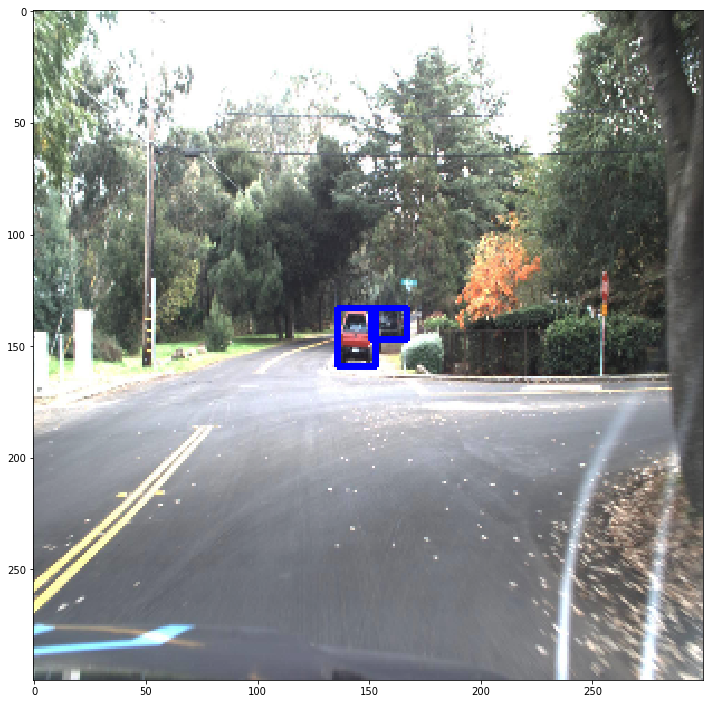

In [41]:
plt.figure(figsize = (12,18))
plt.imshow(pred_img)
plt.show()